In [9]:
import pandas as pd
from sqlalchemy import create_engine
import json

# DB 접속 정보 로드
with open('db-config.json') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

In [ ]:
uv_dataset = pd.read_sql("SELECT * FROM uv_dataset", con=engine)

In [11]:
uv_dataset.columns

Index(['datetime', 'region', 'no2', 'co', 'so2', 'o3', 'pm10', 'pm25',
       'temperature', 'wind_direction', 'wind_speed', 'precipitation',
       'humidity', 'uv_max'],
      dtype='object')

In [12]:
import pandas as pd

# 1. 전체 날짜 생성 (2015.01.01 ~ 2024.12.31)
full_dates = pd.date_range(start="2015-01-01", end="2024-12-31")

# 2. uv_dataset의 datetime 컬럼을 datetime 형식으로 변환 (혹시 몰라서)
uv_dataset['datetime'] = pd.to_datetime(uv_dataset['datetime'])

# 3. 존재하는 날짜들만 추출
existing_dates = pd.to_datetime(uv_dataset['datetime'].unique())

# 4. 누락된 날짜 찾기 (차집합)
missing_dates = full_dates.difference(existing_dates)

# 5. 출력
print(f"누락된 날짜 개수: {len(missing_dates)}")
print("누락된 날짜 예시:")
print(missing_dates[:10])  # 상위 10개만 보기

# 필요시 DataFrame으로 저장
missing_df = pd.DataFrame(missing_dates, columns=["missing_date"])

누락된 날짜 개수: 60
누락된 날짜 예시:
DatetimeIndex(['2015-12-02', '2015-12-03', '2015-12-04', '2015-12-05',
               '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09',
               '2015-12-10', '2015-12-11'],
              dtype='datetime64[ns]', freq=None)


In [13]:
import pandas as pd
import numpy as np

# 1. 전체 날짜 생성
full_dates = pd.date_range(start="2015-01-01", end="2024-12-31")
full_dates_df = pd.DataFrame(full_dates, columns=['datetime'])

# 2. datetime 형식 통일
uv_dataset['datetime'] = pd.to_datetime(uv_dataset['datetime'])

# 3. 누락된 날짜 찾기
missing_dates = full_dates_df[~full_dates_df['datetime'].isin(uv_dataset['datetime'])].copy()
print(f"누락된 날짜 수: {len(missing_dates)}")

# 4. 연도별 평균값 계산 (datetime → year 추가)
uv_dataset['year'] = uv_dataset['datetime'].dt.year
grouped_means = uv_dataset.groupby('year').mean(numeric_only=True).round(2)

# 5. 누락된 날짜에 해당 연도 붙이기
missing_dates['year'] = missing_dates['datetime'].dt.year

# 6. 연도별 평균값을 누락된 날짜에 매핑
#    → year 기준으로 left join
filled_missing = missing_dates.merge(grouped_means, how='left', left_on='year', right_index=True)

# 7. 누락된 row에 region 채우기 (서울시라고 가정)
filled_missing['region'] = '서울시'

# 8. 컬럼 순서 맞추기 (원본 df 기준)
filled_missing = filled_missing[uv_dataset.columns]

# 9. year 컬럼 제거 (정리용, 혹시나 있으면)
uv_dataset.drop(columns='year', inplace=True, errors='ignore')

# 10. 원본 df와 합치기
filled_df = pd.concat([uv_dataset, filled_missing], ignore_index=True)
filled_df = filled_df.sort_values('datetime').reset_index(drop=True)

# 확인
print("최종 행 개수:", len(filled_df))  # 3652일치면 3652개 나와야 함

누락된 날짜 수: 60
최종 행 개수: 3653


In [14]:
filled_df

,datetime,region,no2,co,so2,o3,pm10,pm25,temperature,wind_direction,wind_speed,precipitation,humidity,uv_max,year
0,2015-01-01,서울시,0.026,0.8,0.008,0.032,168.0,42.0,-3.8,358.9,8.3,0.0,71.0,4.7,NaN
1,2015-01-02,서울시,0.048,1.0,0.009,0.034,57.0,27.0,-0.9,359.6,7.0,0.0,82.0,4.7,NaN
2,2015-01-03,서울시,0.079,1.6,0.012,0.020,76.0,50.0,3.0,359.8,3.7,0.0,91.0,4.7,NaN
3,2015-01-04,서울시,0.104,2.7,0.011,0.027,97.0,53.0,8.2,359.3,4.2,0.0,100.0,4.7,NaN
4,2015-01-05,서울시,0.106,2.6,0.018,0.028,133.0,77.0,9.9,359.3,5.0,0.0,100.0,4.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2024-12-27,서울시,0.046,0.8,0.007,0.043,45.0,24.0,2.7,357.4,7.0,0.0,80.0,3.3,NaN
3649,2024-12-28,서울시,0.037,0.8,0.008,0.041,47.0,23.0,1.2,358.6,6.7,0.0,72.0,3.5,NaN
3650,2024-12-29,서울시,0.054,1.1,0.009,0.037,41.0,30.0,6.6,359.7,3.4,0.0,87.0,3.5,NaN
3651,2024-12-30,서울시,0.058,1.3,0.008,0.052,95.0,59.0,10.3,359.5,6.5,0.0,91.0,3.0,NaN


In [15]:
filled_df['datetime'] = pd.to_datetime(filled_df['datetime'])
filled_df = filled_df.sort_values('datetime').reset_index(drop=True)
filled_df.set_index('datetime', inplace=True)

In [17]:
# 종속변수만 뽑기
target = filled_df[['uv_max']]  # 예측 대상

In [18]:
train = target[:-365]  # 최근 1년 제외
test = target[-365:]

In [19]:
#차분확인
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['uv_max'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")  # 0.05 미만이면 정상성 → d = 0

ADF Statistic: -3.9742676960209287
p-value: 0.001551411682271221


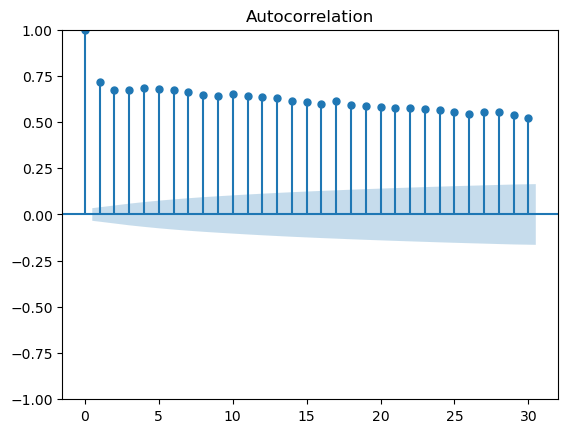

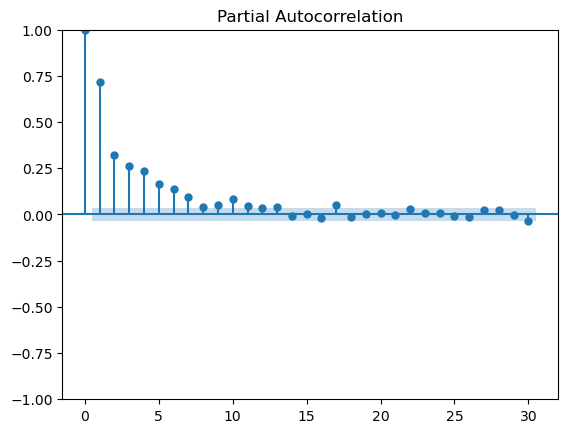

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(train['uv_max'], lags=30)
plt.show()

plot_pacf(train['uv_max'], lags=30)
plt.show()

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# ARIMA 모델 정의 및 학습
model = ARIMA(train['uv_max'], order=(3, 0, 2))
model_fit = model.fit()

# 예측 (test 길이만큼)
forecast = model_fit.forecast(steps=len(test))

# 성능 평가
rmse_arima = sqrt(mean_squared_error(test['uv_max'], forecast))
print(f"ARIMA RMSE: {rmse_arima:.2f}")

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA RMSE: 2.64


In [22]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(train['uv_max'],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=0, seasonal=False,
                        stepwise=True, trace=True)

auto_forecast = auto_model.predict(n_periods=len(test))
rmse_auto = sqrt(mean_squared_error(test['uv_max'], auto_forecast))
print(f"Auto ARIMA RMSE: {rmse_auto:.2f}")

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19843.993, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12392.923, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16996.260, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11813.030, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11491.050, Time=0.32 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10996.134, Time=1.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11004.762, Time=0.90 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=10994.081, Time=1.19 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=10995.674, Time=1.67 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=10995.615, Time=1.37 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=11007.634, Time=1.19 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=10997.845, Time=1.24 sec
 ARIMA(4,0,1)(0,0,0)[0] interce

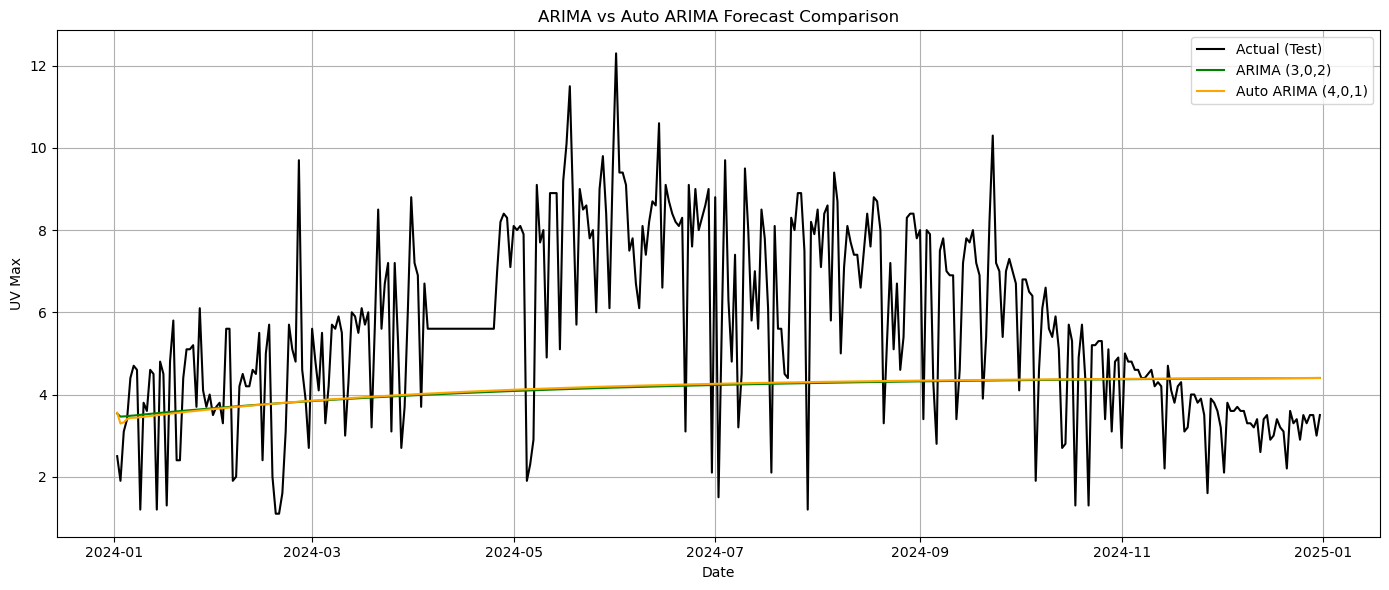

In [25]:
#ARIMA(3,0,2) (4,0,1) test셋으로 비교

import matplotlib.pyplot as plt

# 예측 구간 인덱스
forecast_index = test.index

plt.figure(figsize=(14, 6))

# 실제 값
plt.plot(test.index, test['uv_max'], label='Actual (Test)', color='black')

# 직접 설정한 ARIMA 예측값
plt.plot(forecast_index, forecast, label='ARIMA (3,0,2)', color='green')

# auto_arima 예측값
plt.plot(forecast_index, auto_forecast, label='Auto ARIMA (4,0,1)', color='orange')

plt.title("ARIMA vs Auto ARIMA Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("UV Max")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# train 기간에 대한 인샘플 예측
train_pred = model_fit.predict(start=train.index[0], end=train.index[-1])
train_pred

2015-01-01    4.447590
2015-01-02    4.627989
2015-01-03    4.653161
2015-01-04    4.665224
2015-01-05    4.671639
                ...   
2023-12-28    3.824767
2023-12-29    3.820529
2023-12-30    3.546362
2023-12-31    2.907598
2024-01-01    3.247996
Freq: D, Name: predicted_mean, Length: 3288, dtype: float64

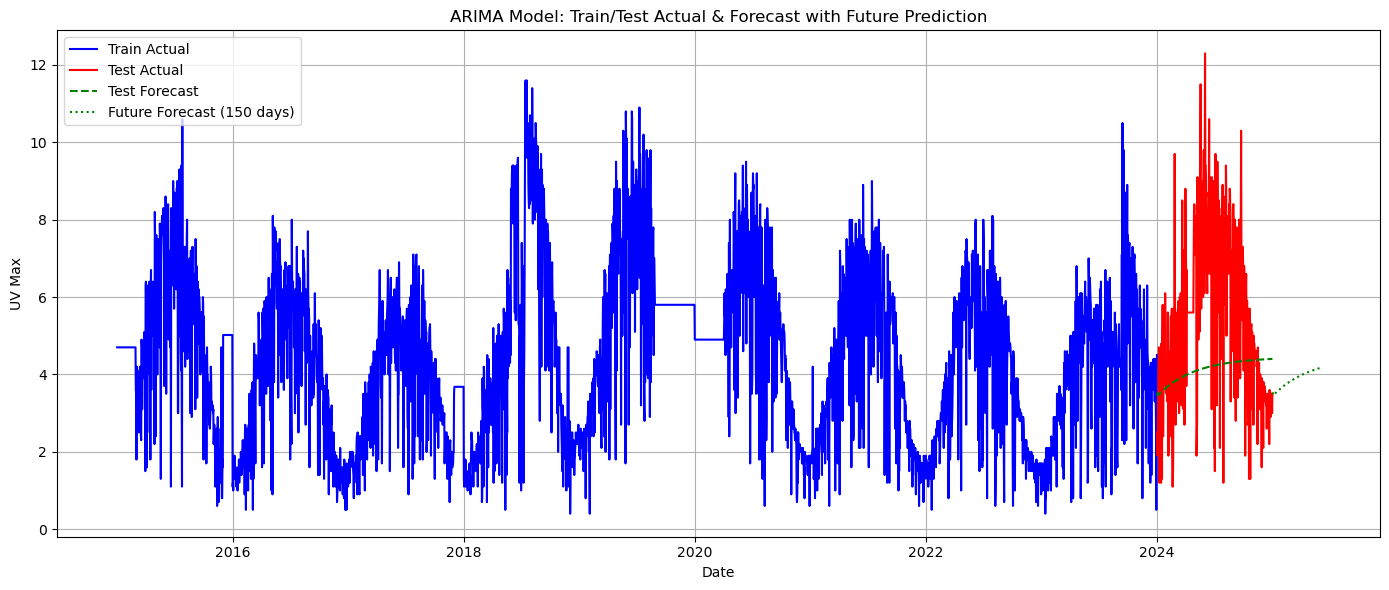

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# train+test 실제 값 concat (index datetime 형식 가정)
actual_all = pd.concat([train['uv_max'], test['uv_max']])

# 미래 예측 (예: 150일) — 변수는 직접 조정하세요
future_steps = 150
last_date = test.index[-1]
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# ARIMA 모델로 미래 예측
arima_forecast_future = model_fit.get_forecast(steps=future_steps)
arima_pred_future = arima_forecast_future.predicted_mean
arima_pred_future.index = future_index

plt.figure(figsize=(14, 6))

# train 실제값 (파란색)
plt.plot(train.index, train['uv_max'], label='Train Actual', color='blue')

# test 실제값 (빨간색)
plt.plot(test.index, test['uv_max'], label='Test Actual', color='red')

# test 기간 예측값 (녹색, 점선)
plt.plot(test.index, forecast, label='Test Forecast', color='green', linestyle='--')

# 미래 예측 (녹색, 점선 스타일 다르게)
plt.plot(future_index, arima_pred_future, label=f'Future Forecast ({future_steps} days)', color='green', linestyle=':')

plt.title("ARIMA Model: Train/Test Actual & Forecast with Future Prediction")
plt.xlabel("Date")
plt.ylabel("UV Max")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 uv_max   No. Observations:                 3288
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -5491.173
Date:                    수, 02 7 2025   AIC                          10996.347
Time:                        03:41:50   BIC                          11039.033
Sample:                    01-01-2015   HQIC                         11011.630
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4476      0.574      7.748      0.000       3.323       5.573
ar.L1          0.1902      0.188      1.014      0.310      -0.177       0.558
ar.L2          0.8675      0.209      4.154      0.0

In [ ]:
#LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 자외선 최대치만 사용
data = seoul_uv['uv_max'].fillna(method='ffill').values.reshape(-1, 1)

# Min-Max 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 슬라이딩 윈도우 설정
INPUT_LEN = 40  # 과거 40일
OUTPUT_LEN = 10  # 예측 10일

C:\Users\user\AppData\Local\Temp\ipykernel_21880\730993574.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = seoul_uv['uv_max'].fillna(method='ffill').values.reshape(-1, 1)


In [ ]:
X, y = [], []

for i in range(len(data_scaled) - INPUT_LEN - OUTPUT_LEN + 1):
    x_seq = data_scaled[i : i + INPUT_LEN]
    y_seq = data_scaled[i + INPUT_LEN : i + INPUT_LEN + OUTPUT_LEN]
    X.append(x_seq)
    y.append(y_seq)

X = np.array(X)
y = np.array(y)

In [ ]:
len(data_scaled), len(X), len(y)

(3593, 3544, 3544)

In [ ]:
# 맨 마지막 샘플 하나만 테스트로 사용
X_train = X[:-1]
y_train = y[:-1]
X_test = X[-1:]
y_test = y[-1:]

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape :", X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape: (3543, 40, 1)
y_train.shape: (3543, 10, 1)
X_test.shape : (1, 40, 1)
y_test.shape : (1, 10, 1)


In [ ]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())

0 0
0 0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from math import sqrt
from sklearn.metrics import mean_squared_error

# 하이퍼파라미터
input_len = X_train.shape[1]
output_len = y_train.shape[1]
feature_dim = X_train.shape[2]

# 모델 정의
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(input_len, feature_dim)),
    Dense(32, activation='relu'),
    Dense(output_len)
])

# 학습
lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

In [ ]:
# 예측
lstm_pred = lstm_model.predict(X_test)

# RMSE
lstm_rmse = sqrt(mean_squared_error(y_test.flatten(), lstm_pred.flatten()))
print(f"LSTM RMSE: {lstm_rmse:.2f}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === ARIMA 시각화 ===
plt.figure(figsize=(14, 6))

# ARIMA용 데이터
plt.plot(train.index, train['uv_max'], label='Train')
plt.plot(test.index, test['uv_max'], label='Test (Actual)', color='orange')
plt.plot(pd.date_range(seoul_uv.index[-1]+pd.Timedelta(days=1), periods=n_periods), forecast, label='ARIMA Forecast', color='green')

plt.title(f"ARIMA Forecast vs Actual (RMSE = {rmse_311:.2f})")
plt.xlabel('Date')
plt.ylabel('UV Max')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === LSTM 시각화 ===

# 학습 데이터 시각화용 (정규화 전 데이터 사용)
train_dates = seoul_uv.index[:len(X_train)]
train_values = scaler.inverse_transform(X_train.reshape(X_train.shape[0], X_train.shape[1]))[:, -1]  # 마지막 step만

# 예측 구간: 2025-01-01 ~ 약 10일치 예측
lstm_forecast_dates = pd.date_range(start='2025-01-01', periods=10, freq='D')

# 예측값: 정규화 해제
y_actual_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_unscaled = scaler.inverse_transform(lstm_pred.reshape(-1, 1)).flatten()

plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_values, label='Train')
plt.plot(lstm_forecast_dates, y_actual_unscaled, label='Actual (Next 10)', color='orange')
plt.plot(lstm_forecast_dates, y_pred_unscaled, label='LSTM Forecast', color='green')

plt.title(f"LSTM Forecast (Next 10 Days) - RMSE: {lstm_rmse:.2f}")
plt.xlabel('Date')
plt.ylabel('UV Max')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()